In [1]:
%load_ext autoreload
%autoreload 2

from ltu_ili_testing import SBI_Fitter, MissingPhotometryHandler
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

Device: cuda
Pytorch version: 2.4.1
ROCM HIP version: 6.1.40093-e3dc58bf0


First load a trained model

In [2]:
grid_path ='/home/tharvey/work/output/BPASS_Chab_LogNorm_5_z_12_phot_grid2.hdf5'

fitter = SBI_Fitter.init_from_hdf5('BPASS_Chab_LogNorm_5_z_12_phot_grid2', 
                                grid_path, return_output=False)

fitter.load_model_from_pkl('/home/tharvey/work/ltu-ili_testing/models/BPASS_Chab_LogNorm_5_z_12_phot_grid2',
                            set_self=True);

Choose a random index from training data

In [59]:
index = np.random.choice(fitter._test_indices)

phot = fitter.feature_array[index]
true_params = fitter.fitted_parameter_array[index]

for i in range(len(phot)):
    print(fitter.feature_names[i], phot[i])

NIRCam.F070W 22.037046
NIRCam.F090W 8.873404
NIRCam.F115W 0.17776059
NIRCam.F140M -0.03629638
NIRCam.F150W -0.06432091
NIRCam.F162M -0.09250049
NIRCam.F182M -0.14682296
NIRCam.F200W -0.14782128
NIRCam.F210M -0.13525641
NIRCam.F250M -0.3071572
NIRCam.F277W -0.35457572
NIRCam.F300M -0.42728263
NIRCam.F335M -0.9462099
NIRCam.F356W -1.0237107
NIRCam.F360M -1.0722799
NIRCam.F410M -1.3729504
NIRCam.F430M -2.1085596
NIRCam.F444W -1.5446899
NIRCam.F460M -1.3281354
NIRCam.F480M -1.3789338
redshift 7.6871076
norm_mUV_AB 36.445976


In [18]:
mask = np.zeros_like(phot, dtype=bool)
# Let's pretend we don't have F460M
mask[-4] = True 

Create an instance of the MissingPhotomeryHandler class from our sbi model

In [67]:
phot_sampler = MissingPhotometryHandler.init_from_sbi_fitter(fitter, verbose=False)

Now we will take our training data, pretend we don't have one filter, and see how well we can recover the missing flux in that filter.

In [83]:
true = []
recovered = []

iters=np.random.choice(fitter._test_indices, size=200, replace=False)

for idx in tqdm(iters):
    phot = fitter.feature_array[idx]

    obs = {
        'mags_sbi': phot,
        'mags_unc_sbi': np.ones_like(phot) * 0.1, # Say we have a 0.1 mag error
        'missing_mask': mask,
    }

    out = phot_sampler.process_observation(obs, noise_generator=None);
    true.append(phot[mask])
    recovered.append(np.mean(out['missing_photometry_dist'], axis=1))

true = np.array(true)
recovered = np.array(recovered)



  0%|          | 0/200 [00:00<?, ?it/s]

100%|██████████| 200/200 [01:13<00:00,  2.73it/s]


Text(0.5, 0, 'True Mag')

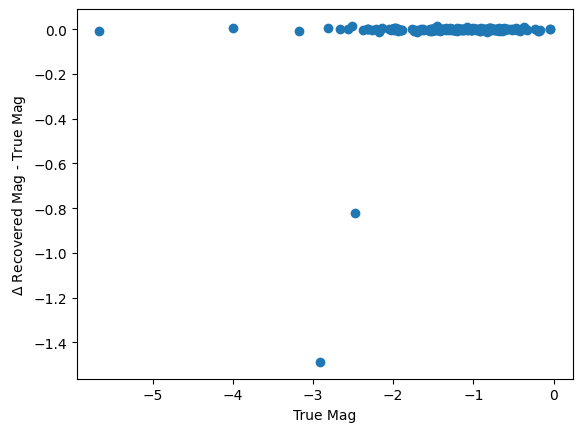

In [82]:
plt.scatter(np.array(true)[:, 0], np.array(true)[:, 0]-recovered,  alpha=1)
plt.ylabel('$\Delta$ Recovered Mag - True Mag')
plt.xlabel('True Mag')

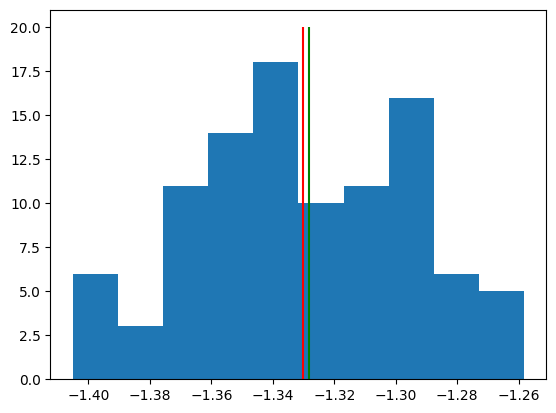

In [62]:
plt.hist(out['missing_photometry_dist'], bins=10);
plt.vlines(out['missing_photometry_dist'].mean(), 0, 20, color='r', label='Mean')
plt.vlines(phot[-4], 0, 20, color='g', label='True Value')

Now a more extreme example, where we remove many filters.

In [ ]:
true = []
recovered = []

iters=np.random.choice(fitter._test_indices, size=200, replace=False)

for idx in tqdm(iters):
    phot = fitter.feature_array[idx]

    obs = {
        'mags_sbi': phot,
        'mags_unc_sbi': np.ones_like(phot) * 0.1, # Say we have a 0.1 mag error
        'missing_mask': mask,
    }

    out = phot_sampler.process_observation(obs, noise_generator=None);
    true.append(phot[mask])
    recovered.append(np.mean(out['missing_photometry_dist'], axis=1))

true = np.array(true)
recovered = np.array(recovered)



In [97]:
# Let's pretend we only have the JADES filters

mask = [1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1]
mask = np.array(mask, dtype=bool)

# Ok, pretending we only had the JADES filters ran into issues with the KDE's and low dimenionality.
# Probably can't stretch the model that far.

# Let's just hide three filters. 

mask = np.zeros_like(phot, dtype=bool)
mask[-3] = True
mask[-5] = True
mask[4] = True


In [120]:
true = []
recovered = []

iters=np.random.choice(fitter._test_indices, size=30, replace=False)

for idx in tqdm(iters):
    phot = fitter.feature_array[idx]

    obs = {
        'mags_sbi': phot,
        'mags_unc_sbi': np.ones_like(phot) * 0.1, # Say we have a 0.1 mag error
        'missing_mask': mask,
    }

    out = phot_sampler.process_observation(obs, noise_generator=None);
    true.append(phot[mask])
    recovered.append(np.mean(out['missing_photometry_dist'], axis=0))

true = np.array(true)
recovered = np.array(recovered)

  0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 30/30 [00:11<00:00,  2.65it/s]


Here we plot for each missing filter the discrepancy between the median recovered flux and the true flux. The closer to zero, the better the recovery. For this naive case, we can recover the flux within around 0.01 magnitudes.

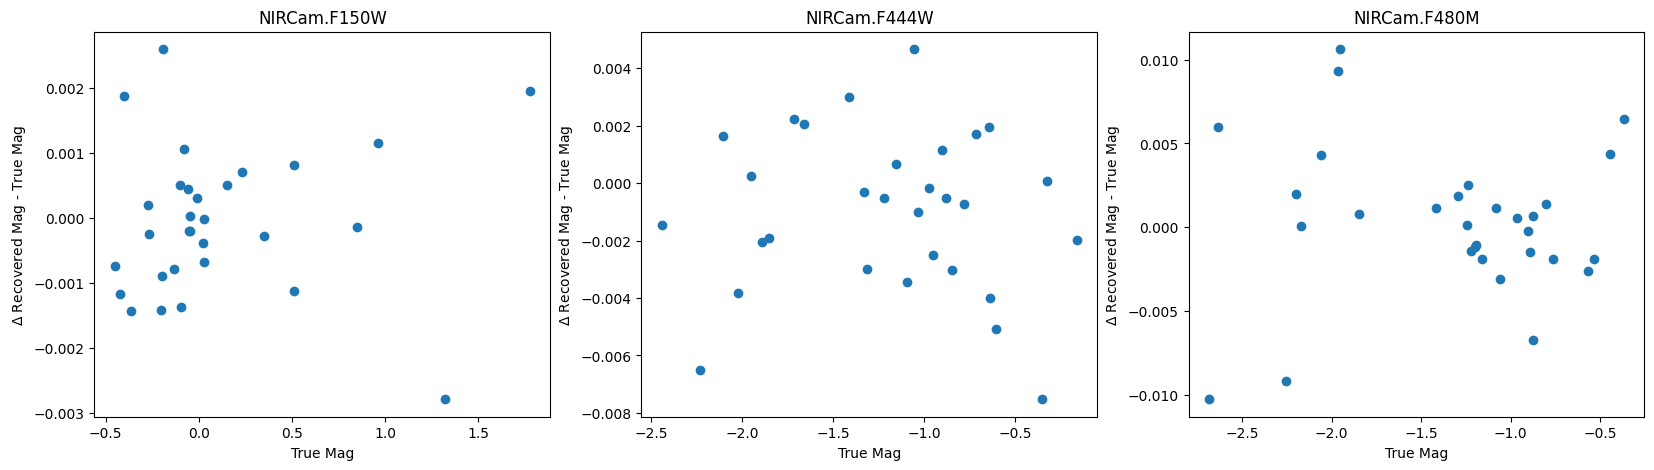

In [121]:
fig, ax = plt.subplots(1, np.sum(mask), figsize=(20, 5))

for i in range(np.sum(mask)):
    ax[i].scatter(np.array(true)[:, i], np.array(true)[:, i]-recovered[:, i],  alpha=1)
    ax[i].set_ylabel('$\Delta$ Recovered Mag - True Mag')
    ax[i].set_xlabel('True Mag')
    missing_filter_idx = np.where(mask)[0][i]
    missing_filter_name = fitter.feature_names[missing_filter_idx]
    ax[i].set_title(missing_filter_name)
   
